In [294]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime


In [295]:

# create a function to calculate the simple moving average
def SMA(data, period=30, column='close'):
    # return numpy array of rolling mean
    return data[column].rolling(window=period).mean()
    

In [296]:
def find_cross(series1, series2):
  # Initialize a list to hold the crossing points
  crossings = []

  # Iterate through the series and check for crossings
  for i in range(1, len(series1)):
    if series1[i] > series2[i] and series1[i-1] <= series2[i-1]:
      # Series1 crosses above Series2 at index i
      crossings.append(i)
    elif series1[i] < series2[i] and series1[i-1] >= series2[i-1]:
      # Series1 crosses below Series2 at index i
      crossings.append(i)

  return crossings

In [297]:
# get github txt file url
url = 'https://raw.githubusercontent.com/Jpaku93/ML_Stock_Regression/main/MES%2006-21.Last.txt'
# read git hub txt file
MES = pd.read_csv(url, names=['time', 'open', 'high', 'low', 'close', 'volume'], delimiter = ";",)

sma21 = SMA(MES, period=21, column='close').to_frame()
sma50 = SMA(MES, period=50, column='close').to_frame()


In [298]:
# create function to signal when to buy and sell an asset
def SMACrossoverSignals(data, SMA1, SMA2, column='close'):
    buyList = []
    sellList = []
    flag = -1
    for i in range(0, len(data)):
        if SMA1[i] > SMA2[i]:
            sellList.append(np.nan)
            if flag != 1:
                buyList.append(data[column][i])
                flag = 1
            else:
                buyList.append(np.nan)
        elif SMA1[i] < SMA2[i]:
            buyList.append(np.nan)
            if flag != 0:
                sellList.append(data[column][i])
                flag = 0
            else:
                sellList.append(np.nan)
        else:
            buyList.append(np.nan)
            sellList.append(np.nan)
    return [buyList, sellList]

In [299]:
# store the buy and sell data into a variable
MES['Buy_Signal_Price'], MES['Sell_Signal_Price'] = SMACrossoverSignals(MES , sma21.close, sma50.close, column='close')
MES['Buy_Signal_Price'] = MES['Buy_Signal_Price'].shift(1)
MES['Sell_Signal_Price'] = MES['Sell_Signal_Price'].shift(1)

In [300]:
MES.shape

(86127, 8)

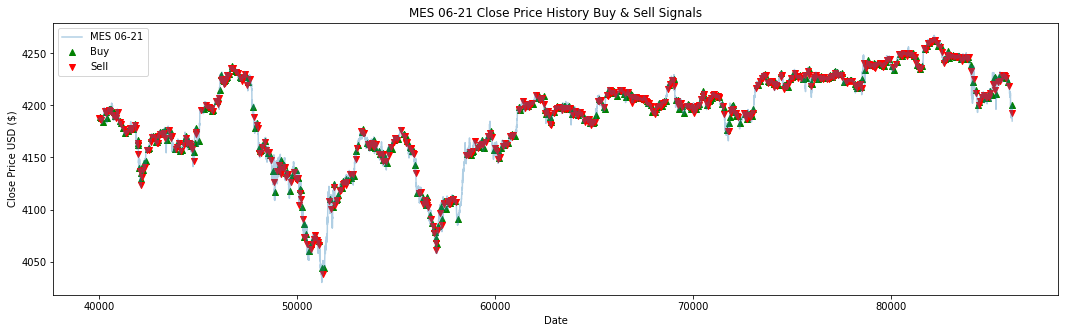

In [301]:
train = MES.copy()[40000:]
test = MES.copy()[:40000]


# visualize the data and the strategy to buy and sell MES
plt.figure (figsize=(18, 5))
plt.plot(train.index, train['close'], label = 'MES 06-21', alpha = 0.35)
# plt.plot(sma21.index, sma21.close.ravel(), label = 'sma21', alpha = 0.25)
# plt.plot(sma50.index, sma50.close.ravel(), label = 'sma50', alpha = 0.25)
plt.scatter(train.index, train['Buy_Signal_Price'], label = 'Buy', marker = '^', color = 'green')
plt.scatter(train.index, train['Sell_Signal_Price'], label = 'Sell', marker = 'v', color = 'red')
plt.title('MES 06-21 Close Price History Buy & Sell Signals')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.legend(loc='upper left')
plt.show()


In [302]:
# def get_pips(data, TAKE_PROFIT = 0.2, STOP_LOSS = 0.2): 
#     copy = data.copy()
#     BUY = 0
#     SELL = 0
#     profit_loss = 0

#     # ITERATE ROWS AND PRINT BUY AND SELL SIGNALS
#     for index, row in copy.iterrows():
#         # GET A BUY SIGNAL
#         if row['Buy_Signal_Price'] > 0:
#             # print("BUY SIGNAL: ", row['Buy_Signal_Price'])
#             BUY = row['Buy_Signal_Price']
#         # READ THE TAKE PROFIT 
#         if BUY != 0 and BUY + TAKE_PROFIT <= row['close']:
#             # CALCULATE PIPS
#             profit_loss += TAKE_PROFIT
#             BUY = 0
#         # READ THE STOP LOSS
#         if BUY != 0 and BUY - STOP_LOSS >= row['close']:
#             # CALCULATE PIPS
#             profit_loss -= STOP_LOSS
#             BUY = 0    
#     return round( profit_loss, 3)

# print("Pips: ", get_pips(MES, TAKE_PROFIT = 0.3, STOP_LOSS = 0.1))

import numpy as np

def get_pips(data, TAKE_PROFIT = 0.2, STOP_LOSS = 0.2): 
    # Pre-allocate memory for the profit_loss array
    profit_loss = np.zeros(data.shape[0])
    
    # Find the indices where the buy signal and take profit conditions are met
    buy_indices = np.where(data['Buy_Signal_Price'] > 0)[0]
    tp_indices = np.where(data['Buy_Signal_Price'] + TAKE_PROFIT <= data['close'])[0]
    # Calculate the profit_loss at the take profit indices
    profit_loss[tp_indices] = TAKE_PROFIT
    
    # Find the indices where the buy signal and stop loss conditions are met
    sl_indices = np.where(data['Buy_Signal_Price'] - STOP_LOSS >= data['close'])[0]
    
    # Calculate the profit_loss at the stop loss indices
    profit_loss[sl_indices] = -STOP_LOSS
    
    # Calculate the total profit_loss
    total_profit_loss = profit_loss.sum()
    
    return round(total_profit_loss, 2)


In [303]:
import numpy as np

def StopLossOptimization(train, take_profit_range, stop_loss_range):
    # Use NumPy's meshgrid function to generate all combinations of take profit and stop loss values
    take_profit_values, stop_loss_values = np.meshgrid(take_profit_range, stop_loss_range)

    # Flatten the arrays to 1D arrays
    take_profit_values = take_profit_values.flatten()
    stop_loss_values = stop_loss_values.flatten()

    # Create a DataFrame with the take profit and stop loss values
    df = pd.DataFrame({'take_profit': take_profit_values.round(2), 'stop_loss': stop_loss_values.round(2)})

    # Use the apply method to calculate the pips for each row
    df['pips'] = df.apply(lambda row: get_pips(train, TAKE_PROFIT=row['take_profit'], STOP_LOSS=row['stop_loss']), axis=1)

    # Pivot the DataFrame to create the final table
    df_final = df.pivot(index='stop_loss', columns='take_profit', values='pips')
    return df_final

In [304]:
# Set the range of values for the take profit and stop loss
take_profit_range = np.arange(0.1, 3.1, 0.1)
stop_loss_range = np.arange(0.1, 3.1, 0.1)

# Call the StopLossOptimization function to get the matrix
matrix = StopLossOptimization(train, take_profit_range, stop_loss_range)

# Find the maximum value
max_value = matrix.values.max()
print("Maximum pips: ", max_value)
# Find the indices of the maximum value
max_indices = np.where(matrix.values == max_value)
# Get the take profit and stop loss values
take_profit = matrix.columns[max_indices[1]][0]
stop_loss = matrix.index[max_indices[0]][0]
print("Take profit: ", take_profit)
print("Stop loss: ", stop_loss)


Maximum pips:  42.5
Take profit:  0.5
Stop loss:  2.8


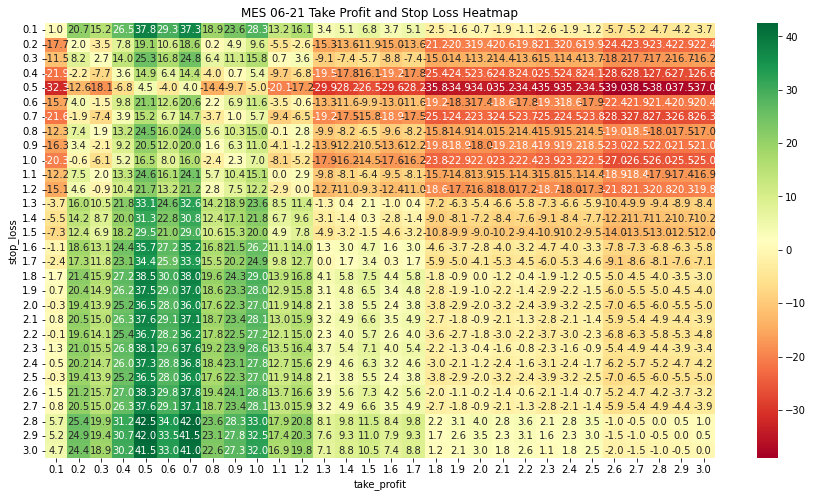

In [305]:
# plot the heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(matrix, annot=True, fmt='.1f', cmap='RdYlGn')
plt.title('MES 06-21 Take Profit and Stop Loss Heatmap')
plt.show()

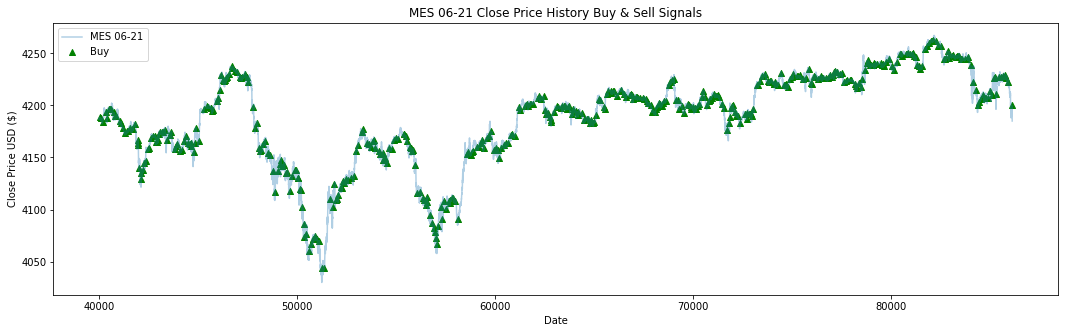

In [307]:
# visualize the data and the strategy to buy and sell MES
plt.figure (figsize=(18, 5))
plt.plot(train.index, train['close'], label = 'MES 06-21', alpha = 0.35)
# plt.plot(sma21.index, sma21.close.ravel(), label = 'sma21', alpha = 0.25)
# plt.plot(sma50.index, sma50.close.ravel(), label = 'sma50', alpha = 0.25)
plt.scatter(train.index, train['Buy_Signal_Price'], label = 'Buy', marker = '^', color = 'green')
# plt.scatter(train.index, train['Sell_Signal_Price'], label = 'Sell', marker = 'v', color = 'red')
plt.title('MES 06-21 Close Price History Buy & Sell Signals')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.legend(loc='upper left')
plt.show()

    